In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

In [5]:
train_set='train'
val_set='val'
test_set='test'

In [6]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [7]:
# image addressing
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size = (224,224),
    batch_size = 8,
    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(
    val_set,
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'binary')
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size = (224,224),
    batch_size = 8,
    class_mode = 'binary')

Found 90 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 21 images belonging to 2 classes.


In [8]:
train_generator.class_indices

{'cancer': 0, 'non-cancer': 1}

In [9]:
base_for_model = tf.keras.applications.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)

58892288/58889256 [==============================] - 5s 0us/step


In [10]:
for layer in base_for_model.layers:
    layer.trainable = False

In [11]:
model = Sequential()
model.add(base_for_model) 
model.add(GaussianNoise(0.25)) #to prevent overfitting
model.add(GlobalAveragePooling2D()) #to converge and reduce the parameters
model.add(Dense(512, activation = 'relu')) #hidden layer (relu activation function is suggested for images)
model.add(BatchNormalization()) #to prevent overfitting
model.add(Dense(1, activation='sigmoid')) #output layer
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
gaussian_noise (GaussianNois (None, 7, 7, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,979,905
Trainable params: 264,193
Non-trainable params: 14,715,712
______________________________________

In [12]:
adam= tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss= 'binary_crossentropy', metrics=['accuracy','Precision','Recall','AUC'])

In [13]:
mp= tf.keras.callbacks.ModelCheckpoint(filepath='mymodel.hdf5', 
                               verbose=2, save_best_only=True)
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=3)
callback=[es,mp]

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=80, #steps_per_epoch= training_images/batch_size= 4946/8<=618
    epochs = 20, #own choice
    validation_data = validation_generator,
    callbacks=callback
)

Epoch 1/20
 9/80 [==>...........................] - ETA: 1:35 - loss: 0.7287 - accuracy: 0.6818 - precision: 0.5172 - recall: 0.6818 - auc: 0.7221

c:\Users\PERSONAL\AppData\Local\Programs\Python\Python37\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


12/80 [===>..........................] - ETA: 1:37 - loss: 0.6873 - accuracy: 0.6778 - precision: 0.5122 - recall: 0.7000 - auc: 0.7450WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1600 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_loss improved from inf to 0.41388, saving model to mymodel.hdf5
12/80 [===>..........................] - 22s 2s/step - loss: 0.6873 - accuracy: 0.6778 - precision: 0.5122 - recall: 0.7000 - auc: 0.7450 - val_loss: 0.4139 - val_accuracy: 0.8500 - val_precision: 1.0000 - val_recall: 0.5714 - val_auc: 0.9341


In [15]:
print(history.history.keys())
import matplotlib.pyplot as plt
acc=(history.history['accuracy'])
loss=(history.history['loss'])
prc=(history.history['precision'])
rec=(history.history['recall'])
auc=(history.history['auc'])
val_acc=(history.history['val_accuracy'])
val_loss=(history.history['val_loss'])
val_prc=(history.history['val_precision'])
val_rec=(history.history['val_recall'])
val_auc=(history.history['val_auc'])

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


In [17]:
model.evaluate(train_generator)

12/12 [==============================] - 17s 1s/step - loss: 0.3352 - accuracy: 0.8889 - precision: 0.9545 - recall: 0.7000 - auc: 0.9622


[0.33524152636528015,
 0.8888888955116272,
 0.9545454382896423,
 0.699999988079071,
 0.962222158908844]

In [18]:
model.evaluate(validation_generator)

3/3 [==============================] - 2s 698ms/step - loss: 0.4468 - accuracy: 0.8500 - precision: 0.8333 - recall: 0.7143 - auc: 0.9505


[0.4467600882053375,
 0.8500000238418579,
 0.8333333134651184,
 0.7142857313156128,
 0.9505494832992554]

In [19]:
model.evaluate(test_generator)

3/3 [==============================] - 2s 799ms/step - loss: 0.4292 - accuracy: 0.8571 - precision: 0.8333 - recall: 0.7143 - auc: 0.9388


[0.4291858673095703,
 0.8571428656578064,
 0.8333333134651184,
 0.7142857313156128,
 0.9387755393981934]

<AxesSubplot:>

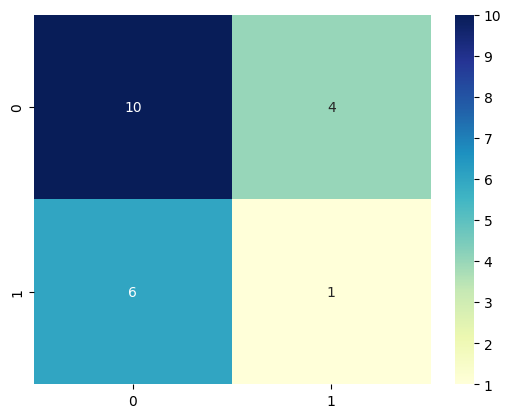

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
predictions = model.predict(test_generator)
test_generator.classes
cm = confusion_matrix(test_generator.classes, predictions.round())

sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

In [21]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, predictions.round())) #.argmax(axis=-1)

              precision    recall  f1-score   support

           0       0.62      0.71      0.67        14
           1       0.20      0.14      0.17         7

    accuracy                           0.52        21
   macro avg       0.41      0.43      0.42        21
weighted avg       0.48      0.52      0.50        21



In [27]:
img = image.load_img(r'C:\Users\PERSONAL\Desktop\oral cancer\data\non-cancer\_tongue.jpg',target_size=(224,224))
imaga = image.img_to_array(img)
image = np.expand_dims(imaga,axis=0)  
ypred = model.predict(image)
if ypred<0.5:
      ypred="non-cancer"
else:
      ypred="cancer" 
plt.imshow(img)
ypred

AttributeError: 'numpy.ndarray' object has no attribute 'load_img'